In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.special import legendre
from scipy.special import hermite
import copy
import pandas as pd
from scipy import integrate
from scipy.special import comb
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm

In [11]:
'''
https://people.sc.fsu.edu/~jburkardt/py_src/monomial/monomial.py
Finds the next monomial multi-index, as explained in the lecture

'''

def next_monomial(m,x):
    j = 0

    for i in range ( 1, m ):
        if ( 0 < x[i] ):
            j = i
            break

    if ( j == 0 ):
        t = x[0]
        x[0] = 0
        x[m-1] = t + 1
    elif ( j < m - 1 ):
        x[j] = x[j] - 1
        t = x[0] + 1;
        x[0] = 0;
        x[j-1] = x[j-1] + t
    elif ( j == m - 1 ):
        t = x[0]
        x[0] = 0
        x[j-1] = t + 1
        x[j] = x[j] - 1

    return x

In [13]:
def f(z1, z2):
    return -abs(z1)**3*z2+np.exp(-(z1-0.5)**2-0.25*z2**2)

In [14]:
M = 1000000
Z = np.zeros((M,2))

Z[:,0] = np.random.uniform(size=M) * 2 - 1
Z[:,1] = np.random.uniform(size=M) * 2 - 1

f_real = f(Z[:,0],Z[:,1])

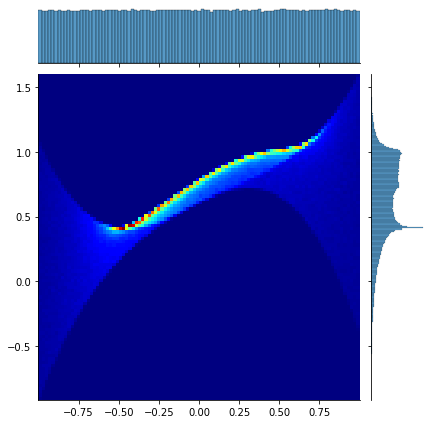

In [15]:
x = Z[:,0]
y = f_real

ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.hist2d(x, y, bins=(100, 100), cmap=cm.jet);

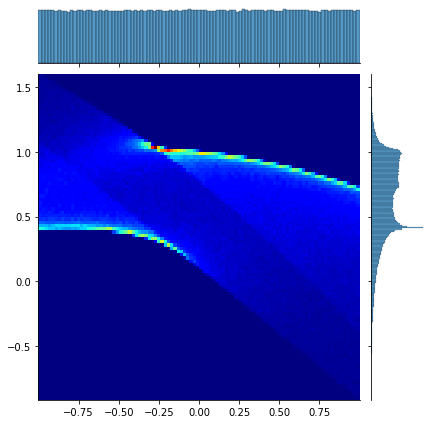

In [16]:
x = Z[:,1]
y = f_real

ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.hist2d(x, y, bins=(100, 100), cmap=cm.jet);

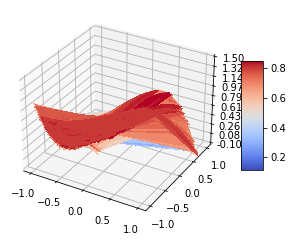

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = Z[1:1000,0]
Y = Z[1:1000,1]
X, Y = np.meshgrid(X, Y)
R = f(X,Y)

surf = ax.plot_surface(X, Y, R, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-.1, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

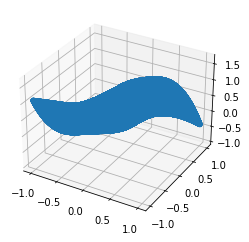

In [18]:
ax = plt.axes(projection='3d')
ax.scatter3D(Z[:,0], Z[:,1], f_real)

In [19]:
N = 2
M = N+1
D=2

In [20]:
x, w = np.polynomial.legendre.leggauss(M)

In [21]:
c=np.zeros(N+1); g=np.zeros(N+1);

In [22]:
# computational grid
l =-1
r=1
dz=0.001;

z=np.linspace(l,r,int((r-l) / dz));
J=len(z)-1;
p1=np.zeros((N+1,J+1)); 
p2=np.zeros((N+1,J+1)); 

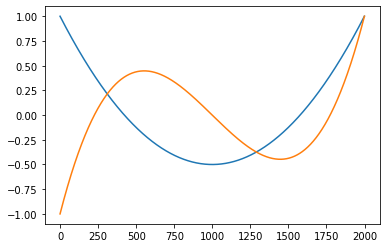

In [23]:
# nice legendre poly's
i=4

plt.plot(legendre(i-2)(z))
plt.plot(legendre(i-1)(z))

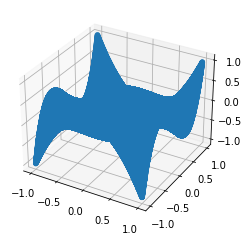

In [24]:
ax = plt.axes(projection='3d')
ax.scatter3D(Z[:,0], Z[:,1], legendre(i-2)(Z[:,0]) * legendre(i-1)(Z[:,1]))

In [25]:
# build monomial multi indices
monomial={}
x=np.array([0,0])
D = 2
N=10
set_size = int(comb(N+D,N))

for i in range(set_size):
    monomial[i] = x.copy()
    x = next_monomial(D,x)

In [26]:
# function to get the multi index gamma from a multi index

# numerical solution in 1D
f_gamma = lambda x, i: legendre(i-1)(x)* legendre(i-1)(x) 

def get_gamma(multi_index, monomial):
    gammas = np.zeros(len(monomial[multi_index]))
    for index, i in enumerate(monomial[multi_index]):
        gammas[index] = integrate.quadrature(f_gamma, -1,1, args=(i+1))[0]
    return np.product(gammas)

In [27]:
def phi(multi_index, Z, monomial):
    ans = legendre(monomial[multi_index][0])(Z[0])
    for i in range(1, len(monomial[multi_index])):
        ans*=legendre(monomial[multi_index][i])(Z[i])
    return ans

In [28]:
def f_hat(z1,z2, multi_index, monomial):
    Z = [z1,z2]
    return f(z1,z2) * phi(multi_index, Z, monomial)

In [29]:
def f_func(z1,z2,multi_index, monomial):
    Z = [z1,z2]
    return f(z1,z2) * phi(multi_index, Z, monomial)

def l_func(z1,z2,multi_index,monomial):
    Z = [z1,z2]
    return phi(multi_index, Z, monomial) * phi(multi_index, Z, monomial)

In [30]:
x, w = np.polynomial.legendre.leggauss(len(monomial.keys()))

In [31]:
c = np.zeros(len(x))
g = np.zeros(c.shape)

In [32]:
for i, multi_index in tqdm(enumerate(monomial.keys())):
    c[i] = integrate.nquad(f_func, ((-1,1), (-1,1)), args=(multi_index, monomial))[0]
    g[i] = integrate.nquad(l_func, ((-1,1), (-1,1)), args=(multi_index, monomial))[0]

66it [00:34,  1.90it/s]


In [33]:
Z = np.array((np.random.uniform(size=100)*2-1, np.random.uniform(size=100)*2-1))

In [34]:
p=np.zeros((len(monomial.keys()),len(Z[0])))
for i, multi_index in enumerate(monomial.keys()):
    p[i,:] = phi(multi_index, Z, monomial)

In [35]:
f_real = f(Z[0], Z[1])

In [36]:
f_a = np.zeros(f_real.shape)

for i, multi_index in enumerate(monomial.keys()):
    f_a += (c[i]/g[i])*p[i]

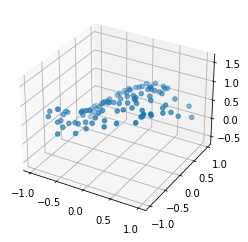

In [37]:
ax = plt.axes(projection='3d')
ax.scatter3D(Z[0],Z[1], f_real)

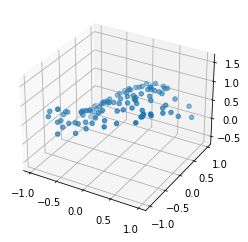

In [38]:
ax = plt.axes(projection='3d')
ax.scatter3D(Z[0],Z[1], f_a)

In [39]:
np.sum(abs(f_real-f_a))/np.sqrt(len(f_real))

0.003041988422235155

In [40]:
N=100
monomial={}
x=np.array([0,0])
D = 2
set_size = int(comb(N+D,N))

for i in range(set_size):
    monomial[i] = x.copy()
    x = next_monomial(D,x)

In [41]:
def run_gPC(N):
    # build multi indices
    monomial={}
    x=np.array([0,0])
    D = 2
    set_size = int(comb(N+D,N))

    for i in range(set_size):
        monomial[i] = x.copy()
        x = next_monomial(D,x)
        
    # calculate f_hat
    # f_hat = <f,phi>/<phi,phi> (inner product is estimated by gaussian quadrature)
    c = np.zeros(len(monomial.keys()))
    g = np.zeros(c.shape)
    
    for i, multi_index in tqdm(enumerate(monomial.keys())):
        c[i] = integrate.nquad(f_func, ((-1,1), (-1,1)), args=(multi_index, monomial))[0]
        g[i] = integrate.nquad(l_func, ((-1,1), (-1,1)), args=(multi_index, monomial))[0]
    
    # Build a computational grid to evaluate f and f_a on
    Z = np.array((np.random.uniform(size=100)*2-1, np.random.uniform(size=100)*2-1))
    
    # Evaluate phi on the computational grid for every multi index
    p=np.zeros((len(monomial.keys()),len(Z[0])))
    for i, multi_index in enumerate(monomial.keys()):
        p[i,:] = phi(multi_index, Z, monomial)
    
    # evaluate the real function
    f_real = f(Z[0], Z[1])
    
    # evaluate the approximation
    # recall that approximation = sum over multi indices of f_hat * phi(Z)
    f_a = np.zeros(f_real.shape)

    for i, multi_index in enumerate(monomial.keys()):
        f_a += (c[i]/g[i])*p[i]
    
    # return the standard error to study convergence
    return np.sum(abs(f_real-f_a))/np.sqrt(len(f_real))

In [42]:
#study convergence
errors = [run_gPC(x) for x in np.arange(2,13)]

6it [00:03,  1.89it/s]
10it [00:04,  2.19it/s]
15it [00:06,  2.33it/s]
21it [00:08,  2.34it/s]
28it [00:11,  2.37it/s]
36it [00:15,  2.30it/s]
45it [00:20,  2.21it/s]
55it [00:28,  1.94it/s]
66it [00:35,  1.88it/s]
78it [00:47,  1.65it/s]
91it [01:06,  1.37it/s]


Text(0, 0.5, 'standard error')

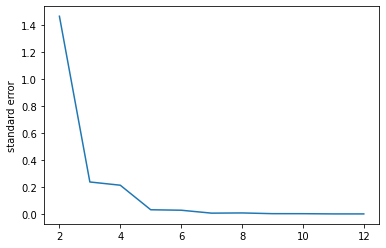

In [43]:
plt.plot(np.arange(2,13), errors)
plt.ylabel("standard error")

In [44]:
# convert to number of functions
D=2
set_sizes = [int(comb(N+D,N)) for N in np.arange(2,13)]

Text(0.5, 0, 'n')

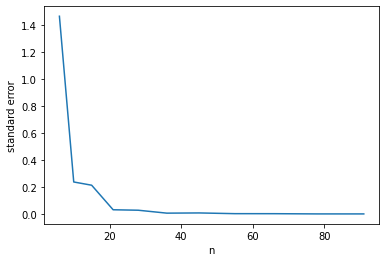

In [45]:
plt.plot(set_sizes, errors)
plt.ylabel("standard error")
plt.xlabel("n")

Text(0.5, 0, 'n')

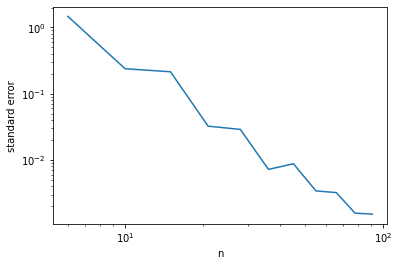

In [46]:
#straight line in log-log plot -> power law -> algebraic convergence!
# needs an explanation
plt.loglog(set_sizes, errors)
plt.ylabel("standard error")
plt.xlabel("n")

In [60]:
# contour plots
xlist = np.linspace(-1.0, 1.0, 100)
ylist = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(xlist, ylist)
f_on_grid = f(X, Y)


In [68]:
plt.rcParams.update({'font.size': 15})

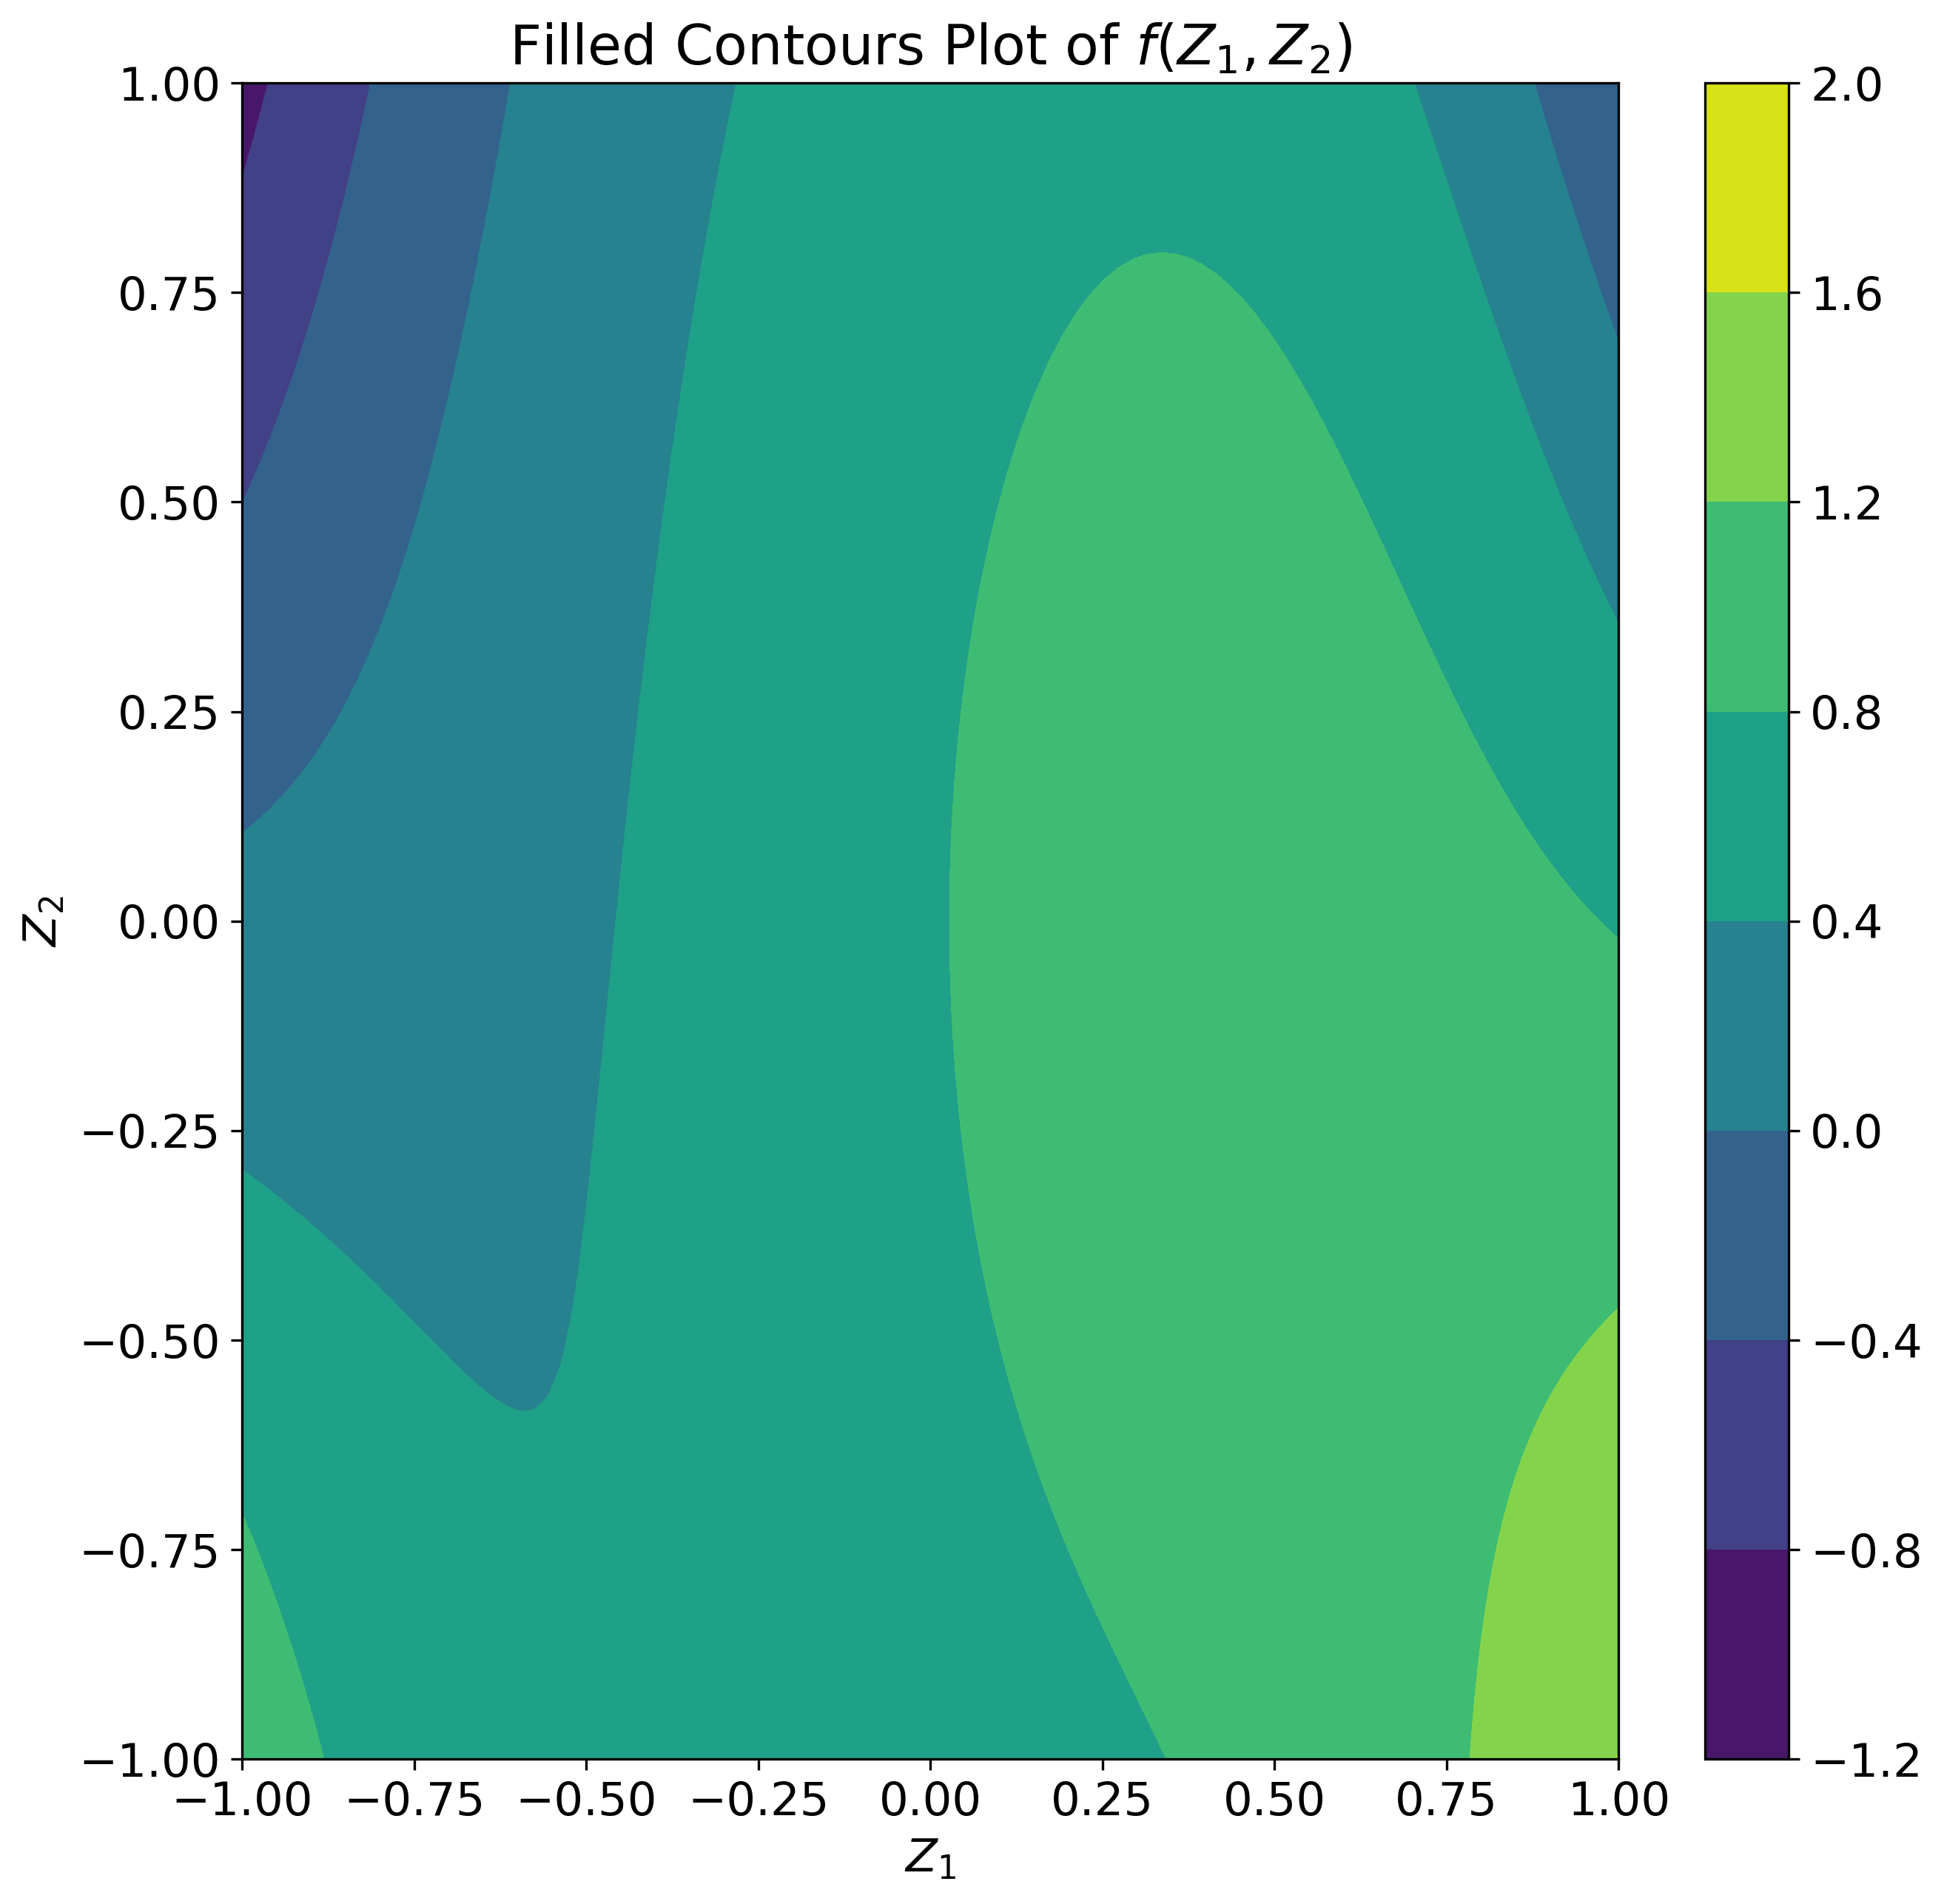

In [71]:
fig,ax=plt.subplots(1,1, figsize=(10,10), dpi = 300)
cp = ax.contourf(X, Y, f_on_grid)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot of $f(Z_{1}, Z_{2})$')
plt.ylabel('$Z_2$')
plt.xlabel('$Z_1$')
plt.savefig('f.jpg')
plt.show()

In [49]:
# save c and g because i don't like to wait
# build multi indices
# use largest N used in latter figures
N=12
monomial={}
x=np.array([0,0])
D = 2
set_size = int(comb(N+D,N))

for i in range(set_size):
    monomial[i] = x.copy()
    x = next_monomial(D,x)

# calculate f_hat
# f_hat = <f,phi>/<phi,phi> (inner product is estimated by gaussian quadrature)
c = np.zeros(len(monomial.keys()))
g = np.zeros(c.shape)

for i, multi_index in tqdm(enumerate(monomial.keys())):
    c[i] = integrate.nquad(f_func, ((-1,1), (-1,1)), args=(multi_index, monomial))[0]
    g[i] = integrate.nquad(l_func, ((-1,1), (-1,1)), args=(multi_index, monomial))[0]

91it [01:06,  1.37it/s]


In [50]:
# evaluate f_a on a meshgrid
# Build a computational grid to evaluate f and f_a on
Z = np.array((xlist, ylist))

# Evaluate phi on the computational grid for every multi index
p=np.zeros((len(monomial.keys()),len(Z[0])))
for i, multi_index in enumerate(monomial.keys()):
    p[i,:] = phi(multi_index, Z, monomial)

# evaluate the real function
f_on_grid = f(X,Y)

# evaluate the approximation
# recall that approximation = sum over multi indices of f_hat * phi(Z)
f_a = np.zeros(f_on_grid.shape)

# get the right evalutions from the mesh grid
i=0
for x_vec in X:
    for k, multi_index in enumerate(monomial.keys()):
        f_a[i,:] += (c[k]/g[k])*phi(multi_index, np.array((x_vec,Y[i,:])), monomial)   
    i+=1

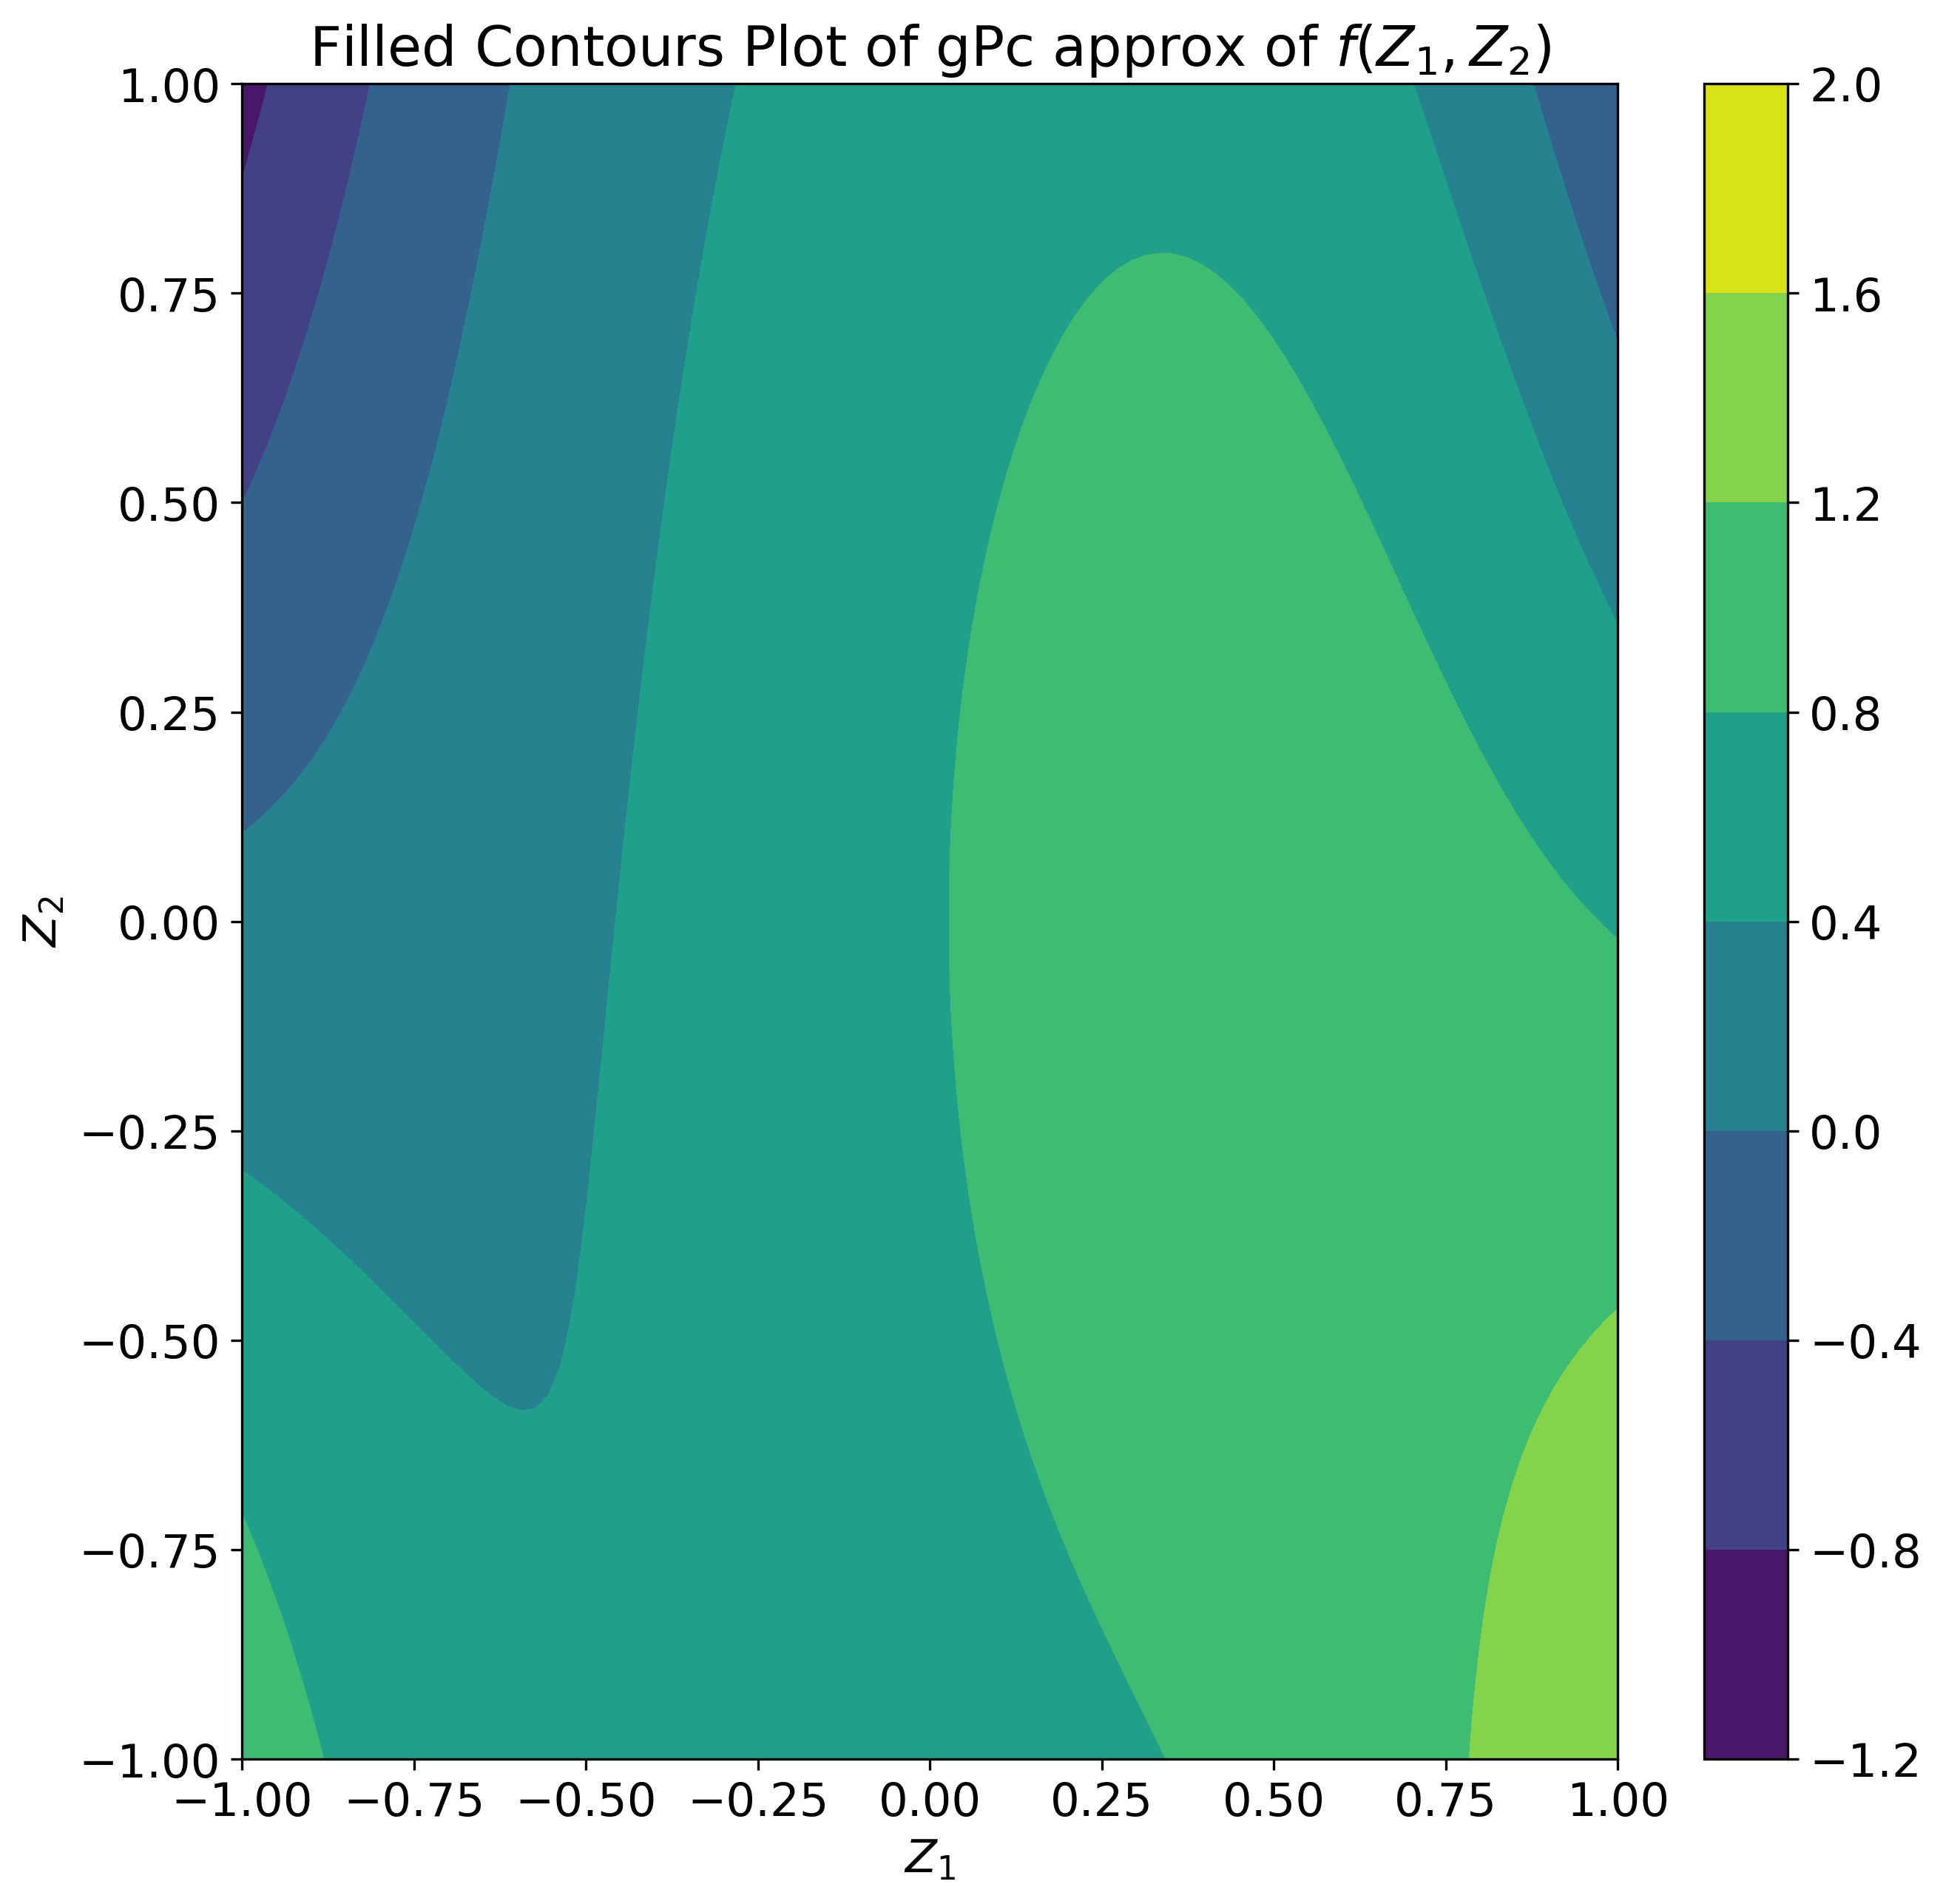

In [72]:
fig,ax=plt.subplots(1,1, figsize=(10,10), dpi = 300)
cp = ax.contourf(X, Y, f_a)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot of gPc approx of $f(Z_{1}, Z_{2})$')
plt.ylabel('$Z_2$')
plt.xlabel('$Z_1$')
plt.savefig('fgpc.jpg')
plt.show()

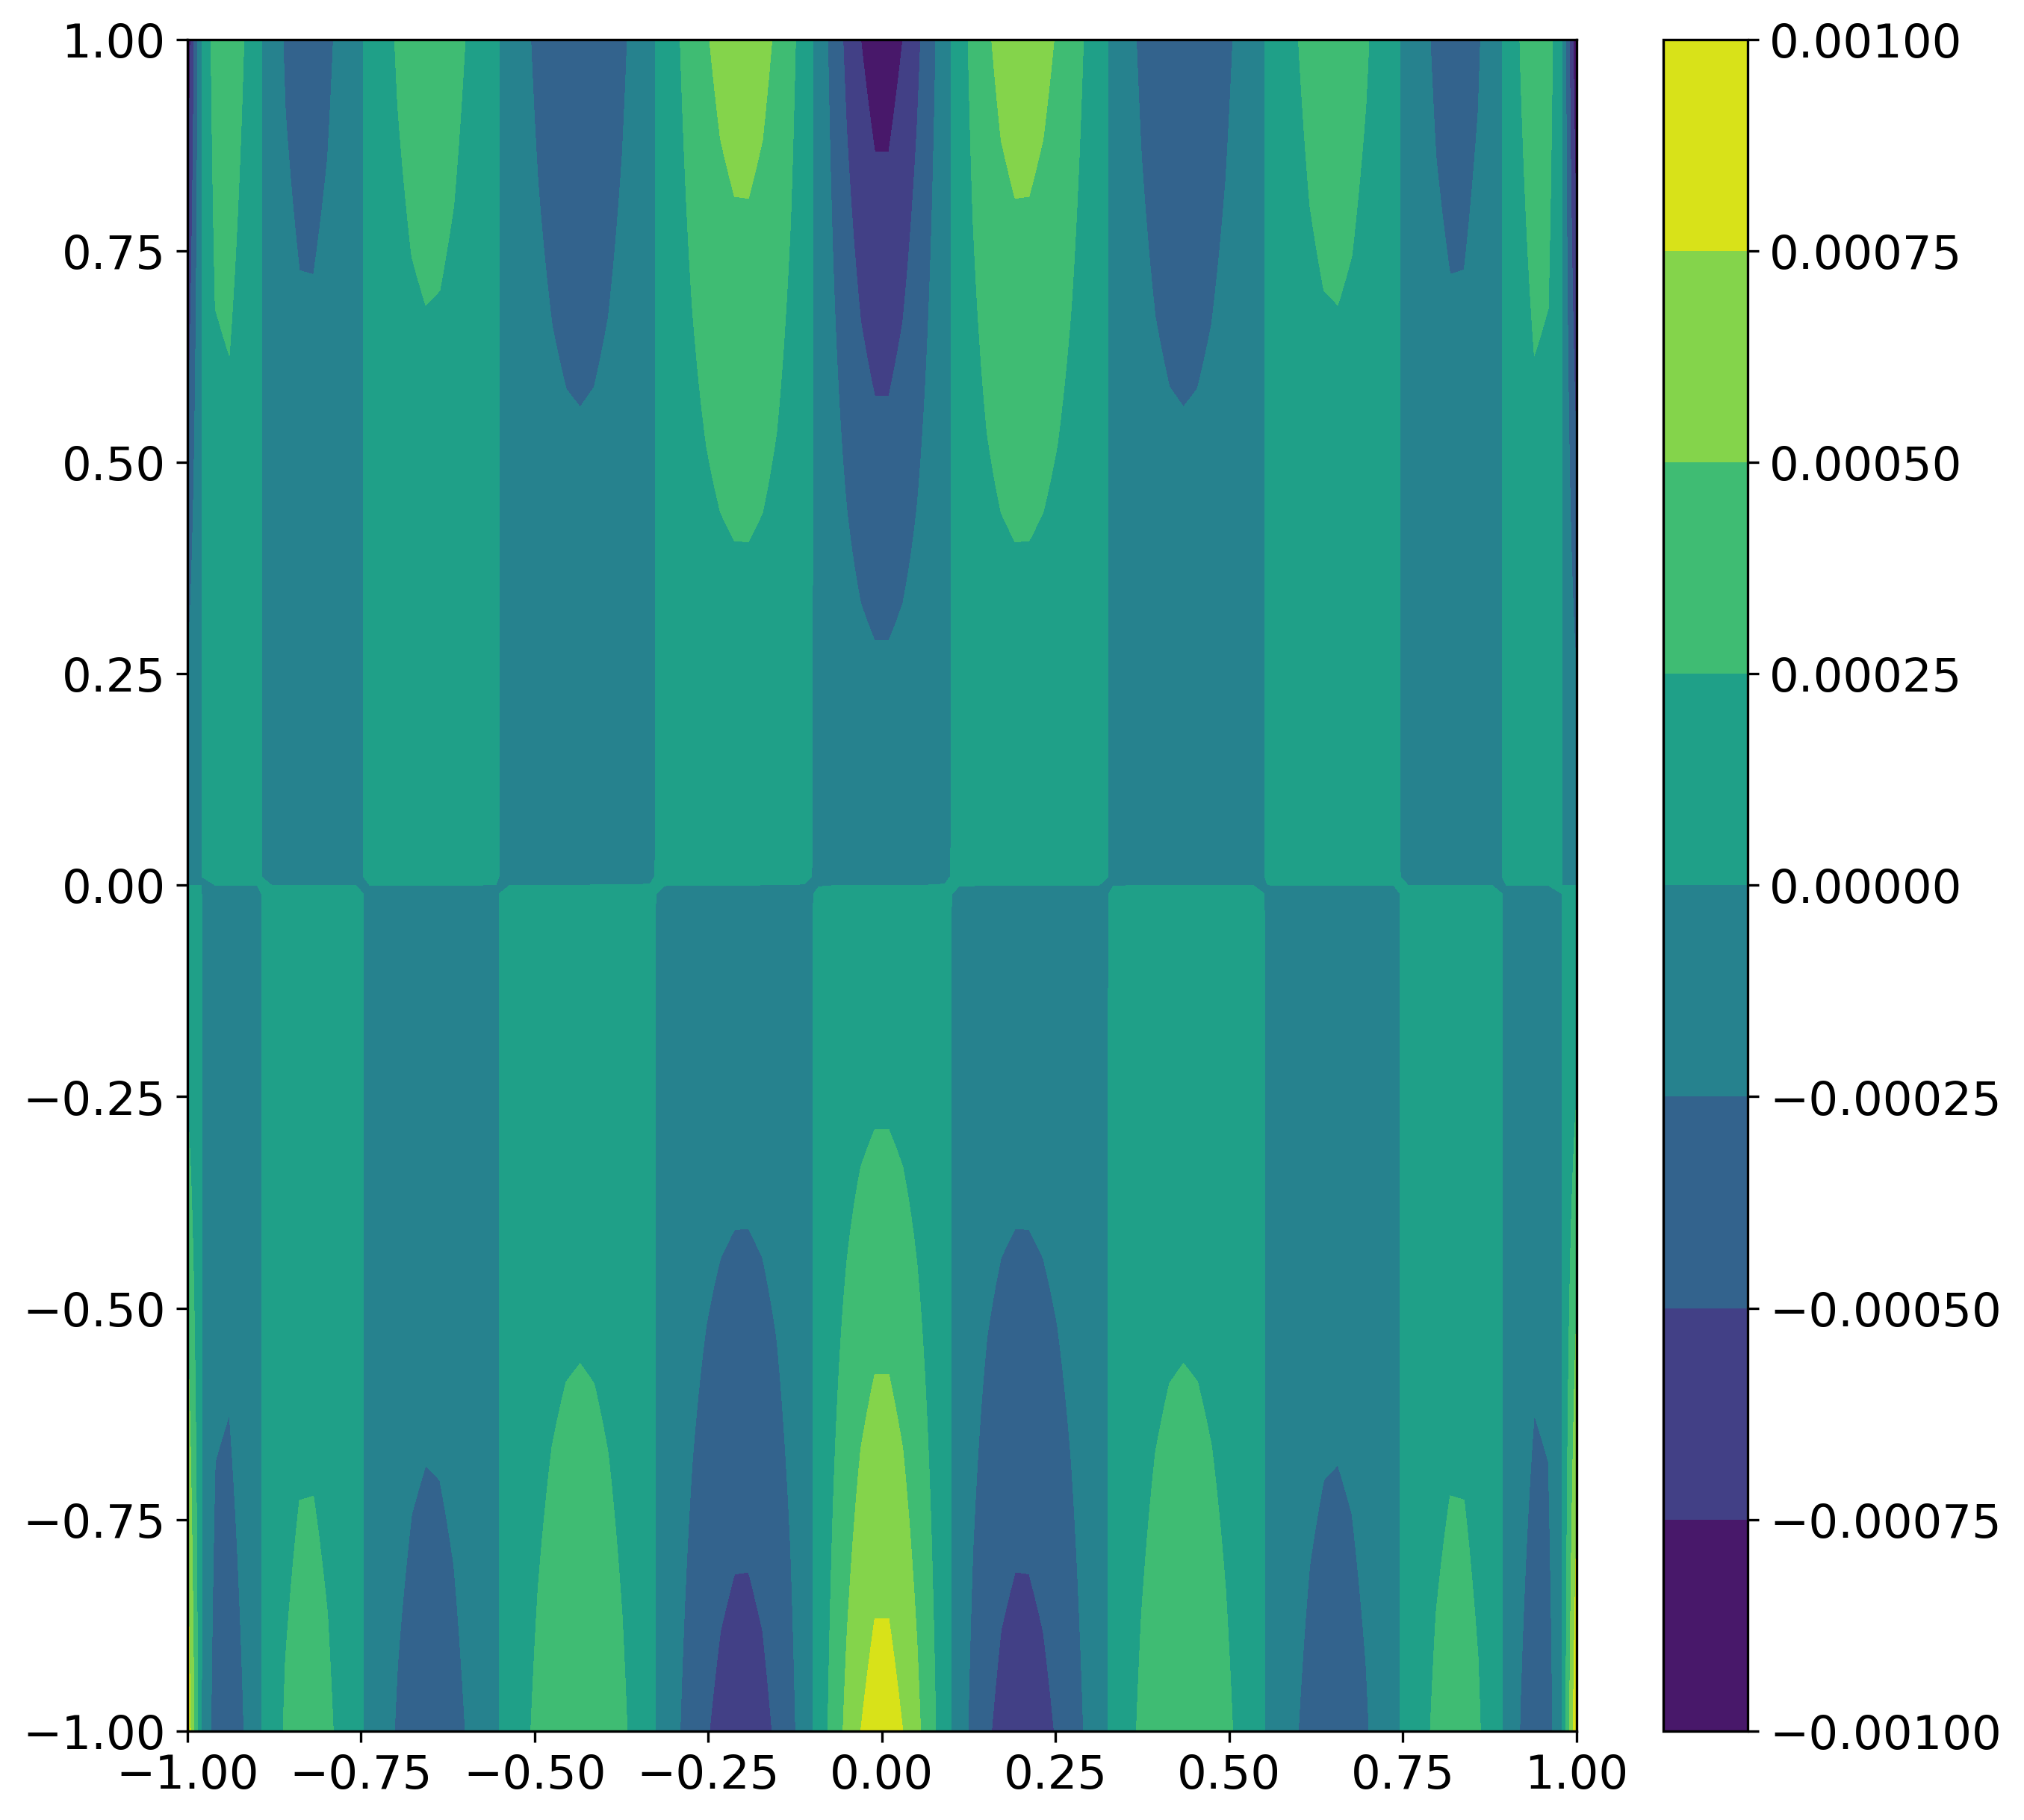

In [76]:
diff = f_on_grid - f_a

fig,ax=plt.subplots(1,1, figsize=(10,10), dpi = 300)
cp = ax.contourf(X, Y, diff)
fig.colorbar(cp) # Add a colorbar to a plot

In [52]:
# mean and variance

In [53]:
# MC mean
np.mean(f_real)

0.5782421413684244

In [83]:
# MC variance
np.var(f_real)

0.14856594573581297

In [55]:
# gPC mean
c[0]/g[0]

0.6077236107674451

In [84]:
# gPC variance- is this correct???
var = 0
for i, multi_index in enumerate(monomial.keys()):
    if i>0:
        var += (c[i]/g[i])*(c[i]/g[i]) * (get_gamma(i, monomial))
var

0.514728137177306